<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>

</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 1
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [ ]:
name = "Seyed Mohammad Eshtehardian"
studentId = "402200948"

It is recommended to open this notebook in Google Colab from [here](https://colab.research.google.com/drive/1tPrFiVeEtt76GIoImPOuv7NA9hKorlue?usp=sharing) and create a copy. You can comment your questions on the notebook as well.

In this exercise we want to gain hands-on experience with Normalizing Flow Models.
1. We want to implement a simple flow model from scratch. (GPU not required)
2. We will use a flow model to perform image in-painting. (GPU recommended)

# Section 1: Flow From Scratch

In [ ]:
# @title imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torchvision as tv

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # you can change this if you like

One of the challenges in creating flow models is creating invertible transformations. Also we would like it if computation of their inverse and/or the log determinant of their jacobian were simple.

In [ ]:
# @title base transform abstract class

class InverseNotAvailable(Exception):
    """Exception to be thrown when a transform does not have an inverse."""

    pass

class Transform(nn.Module):
    """Base class for all transform objects."""

    def forward(self, inputs, context=None):
        raise NotImplementedError()

    def inverse(self, inputs, context=None):
        raise InverseNotAvailable()


First we can create a random permutation transform

In [ ]:
class PermutationTransform(Transform):
    def __init__(self, num_features):
        super().__init__()
        permutation = torch.randperm(num_features)
        self.register_buffer('permutation', permutation)
        self.register_buffer('inverse_permutation', torch.argsort(permutation))

    def forward(self, inputs, context=None):
        return inputs[:, self.permutation], 0  # Log-det is zero

    def inverse(self, inputs, context=None):
        return inputs[:, self.inverse_permutation]

Now  lets create a simple Coupling Transform.

In [ ]:
class CouplingTransform(Transform):
    def __init__(self, mask, hidden_dims, s_net_f=None, t_net_f=None):
        """
        Args:
            mask: a 1-dim tensor, tuple or list. It indexes inputs as follows:
                * If `mask[i] > 0`, `input[i]` will be transformed.
                * If `mask[i] <= 0`, `input[i]` will be passed unchanged.
            hidden_dims: Number of hidden units in the coupling neural networks.
            s_net_f: A function taking (input_dim, output_dim, hidden_dims) returning a Neural Network for Scaling function
            t_net_f: A function taking (input_dim, output_dim, hidden_dims) returning a Neural Network for Translating function
        """
        super(CouplingTransform, self).__init__()

        mask = torch.as_tensor(mask, dtype=torch.float32)
        if mask.dim() != 1:
            raise ValueError("Mask must be a 1-dim tensor.")
        if mask.numel() <= 0:
            raise ValueError("Mask can't be empty.")

        self.register_buffer('mask', mask)

        self.num_features = self.mask.numel()
        features_vector = torch.arange(self.num_features)

        #TODO
        self.s_net, self.t_net = None, None
        if s_net_f is None:
          self.s_net = self._net(self.num_features, self.num_features, hidden_dims)
        else:
          self.s_net = s_net_f(self.num_features, self.num_features, hidden_dims)
        if t_net_f is None:
          self.t_net = self._net(self.num_features, self.num_features, hidden_dims)
        else:
          self.t_net = t_net_f(self.num_features, self.num_features, hidden_dims)



    def _net(self, input_dim, output_dim, hidden_dims):
        # TODO
        if type(hidden_dims) == int:
            hidden_dims = [hidden_dims]
        layers = [nn.Linear(input_dim, hidden_dims[0]), nn.ReLU()]
        if len(hidden_dims) >= 2:
          for i in range(len(hidden_dims)-2):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        return nn.Sequential(*layers)

    def forward(self, inputs, context=None):
        if inputs.dim() != 2:
            raise ValueError("Inputs must be a 2D tensor.")

        if inputs.shape[1] != self.num_features:
            raise ValueError(
                f"Expected features = {self.num_features}, got {inputs.shape[1]}."
            )
        # TODO

        # optional: Use tanh to keep scaling factors bounded

        z, log_det_J = None, None

        masked_inputs = inputs * self.mask
        s = self.s_net(masked_inputs)
        t = self.t_net(masked_inputs)
        s = torch.tanh(s)
        z = masked_inputs + (1 - self.mask) * (inputs * torch.exp(s) + t)
        log_det_J = torch.sum((1 - self.mask) * s, dim=1)

        return z, log_det_J

    def inverse(self, inputs, context=None):
        if inputs.dim() != 2:
            raise ValueError("Inputs must be a 2D tensor.")

        if inputs.shape[1] != self.num_features:
            raise ValueError(
                f"Expected features = {self.num_features}, got {inputs.shape[1]}."
            )

        # TODO

        masked_inputs = inputs * self.mask
        s = self.s_net(masked_inputs)
        t = self.t_net(masked_inputs)
        s = torch.tanh(s)
        z = masked_inputs + (1 - self.mask) * ((inputs - t) * torch.exp(-s))

        return z

In this step we want to implement a simple Normalizing Flow Model similar to RealNVP. First we should create our base flow module. This base module is flexible in that it can have any number of transformations that inherit from the base transformation class.

In [ ]:
# Flow Model
class Flow(nn.Module):
    def __init__(self, transforms, base_distribution=None):
        super(Flow, self).__init__()
        self.transforms = nn.ModuleList(transforms).to(device)
        self.num_features = self.transforms[0].num_features
        if base_distribution is None:
            self.base_distribution = D.MultivariateNormal(
                loc=torch.zeros(self.num_features, device=device),
                covariance_matrix=torch.eye(self.num_features, device=device)
            )
        else:
            self.base_distribution = base_distribution

    def forward(self, x):
        # TODO
        log_det_J = 0
        for tr in self.transforms:
          x, ldJ = tr(x)
          log_det_J += ldJ
        return x, log_det_J

    def inverse(self, z):
        # TODO
        for tr in reversed(self.transforms):
          z = tr.inverse(z)
        return z

    def log_prob(self, x):
        # TODO
        # hint: use base_distribution.log_prob(args)
        z, log_det_J = self.forward(x)
        log_prob_z = self.base_distribution.log_prob(z)
        return log_prob_z + log_det_J

    def sample(self, num_samples):
        # TODO
        # hint: use base_distribution.sample(args)
        z = self.base_distribution.sample((num_samples,))
        x = self.inverse(z)
        return x

    def sample_and_log_prob(self, num_samples):
        # TODO
        z = self.base_distribution.sample((num_samples,))
        x = self.inverse(z)
        log_prob = self.log_prob(x)
        return x, log_prob

Now  we initialize the model and coupling layers. We then train the model on the simple Moons dataset and visualize its learning process through its latent space.

In [ ]:
# Utility function to create alternating masks
def create_alternating_masks(num_features, num_masks):
    masks = []
    for i in range(num_masks):
        mask = [(i + j) % 2 for j in range(num_features)]
        masks.append(mask)
    return masks

In [ ]:
# Hyperparameters
num_features = 2
num_layers = 4
hidden_dims = 64
batch_size = 256
learning_rate = 1e-3
num_epochs = 500

Our flow model can be comprised by CouplingTransforms each followed by a PermutationTransform. You are free to use other architectures or implement other transform as long as they are correct.

You may use a Multivariate Normal distribution.

In [ ]:
# Define masks for alternating coupling layers
masks = create_alternating_masks(num_features, num_layers)

# Initialize transforms
transforms = []
for i in range(num_layers):
    transforms.append(CouplingTransform(masks[i], hidden_dims))
    transforms.append(PermutationTransform(num_features))

# Initialize base distribution


# Initialize Flow model
flow = Flow(transforms=transforms, base_distribution=None).to(device)


Epoch 1/500, Loss: 2.6097


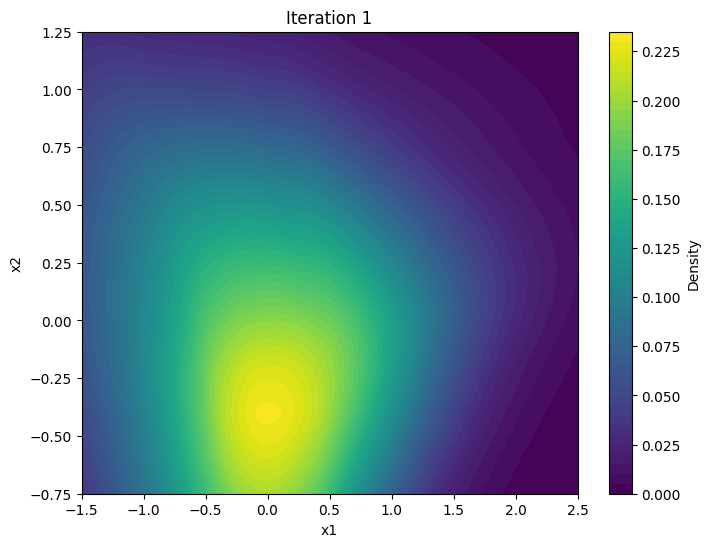

Epoch 200/500, Loss: 1.5540


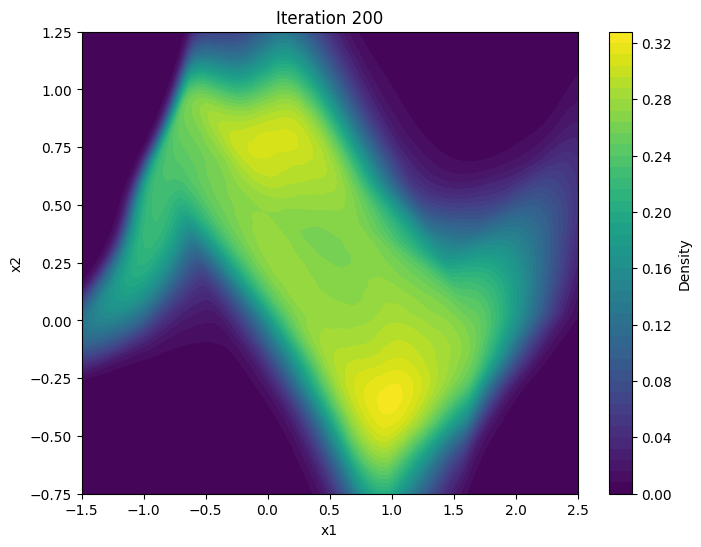

Epoch 400/500, Loss: 1.4222


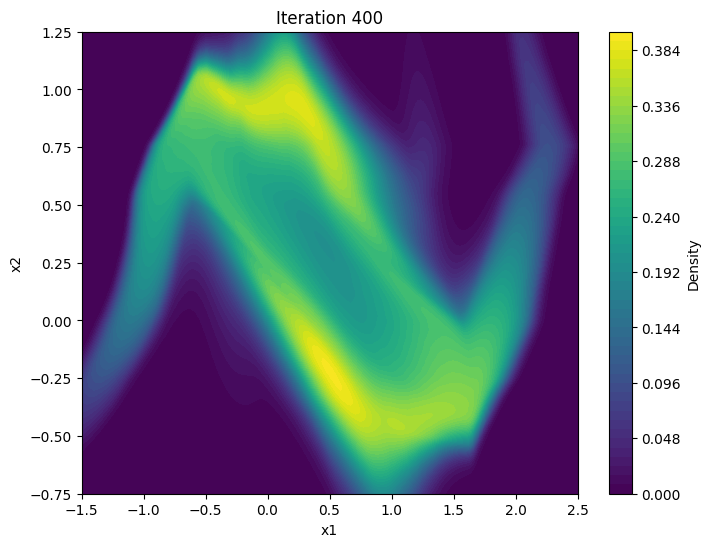

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

# Training loop
for epoch in range(1, num_epochs + 1):
    # Generate batch data
    x, _ = make_moons(n_samples=batch_size, noise=0.1)
    x = torch.tensor(x, dtype=torch.float32).to(device)

    #TODO
    optimizer.zero_grad()
    loss = -flow.log_prob(x).mean()

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")

        # Visualization of the learned density
        with torch.no_grad():
            xline = torch.linspace(-1.5, 2.5, 200, device=device)
            yline = torch.linspace(-0.75, 1.25, 200, device=device)
            xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
            xyinput = torch.cat([
                xgrid.reshape(-1, 1),
                ygrid.reshape(-1, 1)
            ], dim=1).to(device)

            log_prob_grid = torch.zeros(200, 200).to(device)
            for i in range(200):
              for j in range(200):
                log_prob_grid[i, j] = flow.log_prob(torch.Tensor([[xline[i], yline[j]]]).to(device))
            zgrid = torch.exp(log_prob_grid).reshape(200, 200).cpu()

        plt.figure(figsize=(8, 6))
        plt.contourf(
            xgrid.cpu().numpy(),
            ygrid.cpu().numpy(),
            zgrid.numpy(),
            levels=50,
            cmap='viridis'
        )
        plt.title(f'Iteration {epoch}')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.colorbar(label='Density')
        plt.show()

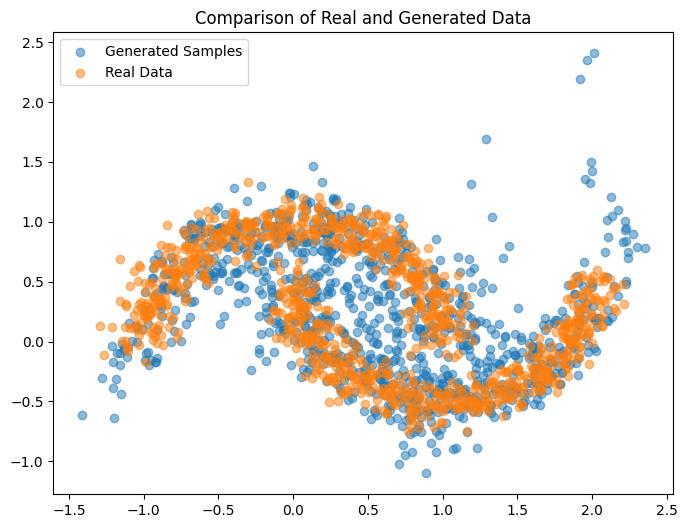

In [ ]:
# Sampling from the flow
with torch.no_grad():
    samples = flow.sample(1000).cpu().numpy()
    x_real, _ = make_moons(1000, noise=0.1)

    plt.figure(figsize=(8, 6))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Generated Samples')
    plt.scatter(x_real[:, 0], x_real[:, 1], alpha=0.5, label='Real Data')
    plt.legend()
    plt.title('Comparison of Real and Generated Data')
    plt.show()

# Section 2:Flows In Action

Here, we show how a flow can be trained to generate images with the `normflows` package. The flow is a [Glow](https://arxiv.org/abs/1807.03039) model, which is based on the [multi-scale architecture](https://arxiv.org/abs/1605.08803). This Glow model is applied to the MNIST dataset.

## Perparation

To get started, we have to install the `normflows` package.

In [1]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87244 sha256=a8e409cf9e05fe23e3b1901a5f07815d1b7e6d511e856f3227dec3ad657a122e
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [2]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm
import os

Glow consists of `nf.flows.GlowBlocks`, that are arranged in a `nf.MultiscaleFlow`, following the multi-scale architecture. The base distribution is a `nf.distributions.DiagGaussian`, which is a diagonal Gaussian.

In [3]:
# Define the directory to save checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


In [4]:
# Set up model (nothing TODO here)

# Define flows
L = 2
K = 16
torch.manual_seed(0)

input_shape = (1, 28, 28)
n_dims = np.prod(input_shape)
channels = 1
hidden_channels = 128
split_mode = 'channel'
scale = True

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i),
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L,
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.DiagGaussian(latent_shape)]


# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:857: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1990.)
  LU, pivots, infos = torch._lu_with_info(


In [5]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [6]:
# @title loading MNIST dataset with TorchVision

batch_size = 128

transform = tv.transforms.Compose([tv.transforms.ToTensor(),
                                  #  nf.utils.Scale(255. / 256.),
                                   nf.utils.Jitter(1 / 256.)])

train_data = tv.datasets.MNIST('datasets/', train=True,
                                 download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                           drop_last=True)

test_data = tv.datasets.MNIST('datasets/', train=False,
                                download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.6MB/s]


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 349kB/s]


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.69MB/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



## Training

Now, can train the model on the image data. you can change this code to your prefered style as long as it is correct and the result is reasonable.

In [7]:
# Train model
max_iter = 10000
save_every = 2000  # Save every 2000 iterations

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_iter = iter(train_loader)

cnt = 0
for i in tqdm(range(max_iter)):
## TODO training loop ( hint: use model.forward_kld(x), gives the log prob  )
    optimizer.zero_grad()
    x = next(train_iter)[0].to(device)
    loss = model.forward_kld(x)
    loss.backward()
    optimizer.step()
    if cnt == len(train_iter) - 1:
      train_iter = iter(train_loader)
      cnt = 0
    else:
      cnt += 1

    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

    # Save checkpoint periodically
    if (i + 1) % save_every == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_iter_{i+1}.pth')
        torch.save({
            'iteration': i + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_hist': loss_hist,
        }, checkpoint_path)
        print(f'Checkpoint saved at iteration {i+1} to {checkpoint_path}')

 20%|██        | 2001/10000 [04:43<26:54,  4.96it/s]

Checkpoint saved at iteration 2000 to checkpoints/model_iter_2000.pth


 40%|████      | 4001/10000 [09:22<14:52,  6.72it/s]

Checkpoint saved at iteration 4000 to checkpoints/model_iter_4000.pth


 60%|██████    | 6001/10000 [13:56<10:24,  6.41it/s]

Checkpoint saved at iteration 6000 to checkpoints/model_iter_6000.pth


 80%|████████  | 8001/10000 [18:29<05:05,  6.54it/s]

Checkpoint saved at iteration 8000 to checkpoints/model_iter_8000.pth


100%|██████████| 10000/10000 [23:08<00:00,  7.20it/s]

Checkpoint saved at iteration 10000 to checkpoints/model_iter_10000.pth


In [8]:
# Save the final model after training
final_checkpoint_path = os.path.join(checkpoint_dir, 'model_final.pth')
torch.save({
    'iteration': max_iter,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_hist': loss_hist,
}, final_checkpoint_path)
print(f'Final model saved to {final_checkpoint_path}')

Final model saved to checkpoints/model_final.pth


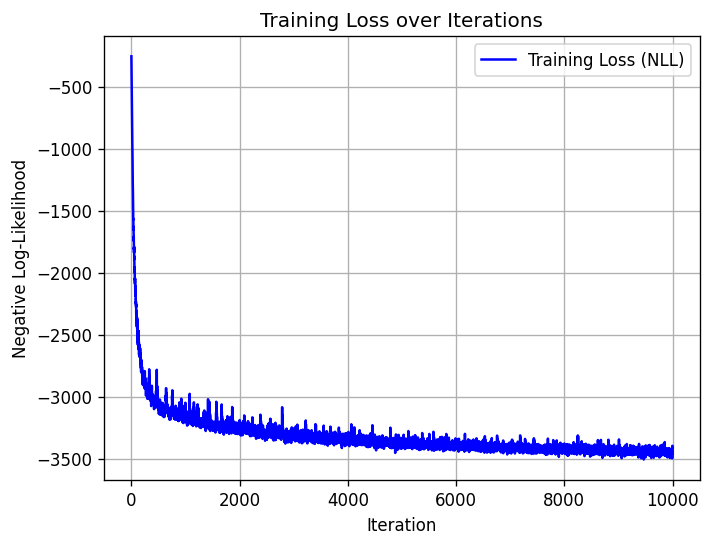

In [9]:
# TODO Plot training loss
plt.figure(dpi=120)
plt.plot(loss_hist, 'b', label='Training Loss (NLL)')
plt.title('Training Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Negative Log-Likelihood')
plt.legend()
plt.grid()

## Evaluation

To evaluate our model, we can just draw samples from our model.

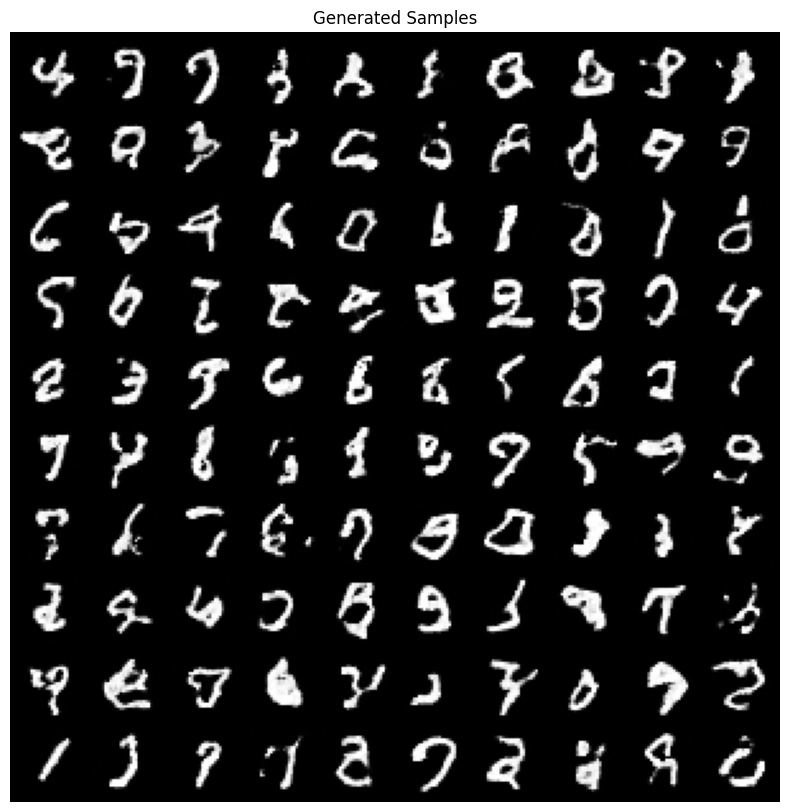

In [10]:
# Model samples
num_samples_per_grid = 10  # Number of samples per grid row
total_samples = num_samples_per_grid * num_samples_per_grid  # Total samples to generate


with torch.no_grad():
    # Sample from the base distribution
    x, _ = model.sample(num_samples_per_grid ** 2)  # No class labels needed
    x_ = torch.clamp(x, 0, 1)

    # Arrange samples in a grid
    grid = tv.utils.make_grid(x_, nrow=num_samples_per_grid)

    # Plot the grid of samples
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Generated Samples')
    plt.show()

Note that to get competitive performance, a much larger model than specified in this notebook, which is trained over more iterations, is needed.

## In-Painting

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim

Now you are supposed to create a function that masks a random square of the image, and a function that fills the missing part based on maximum liklihood using the trained flow model.

In [12]:
def apply_random_square_mask(image, mask_size=8):
    """
    Applies a random square mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        mask_size (int): Size of the square mask.

    Returns:
        masked_image (torch.Tensor): Image with the masked square.
        mask (torch.Tensor): Binary mask indicating masked regions (1 for masked).
    """
    _, H, W = image.shape
    masked_image = image.clone()
    # TODO:
    mask = torch.zeros( H, W) # = Single channel(MNIST) square mask

    # suggestion: Sample a random top-left corner for the square
    x0, y0 = torch.randint(0, H-mask_size, (1,))[0], torch.randint(0, W-mask_size, (1,))[0]
    mask[x0:x0+mask_size, y0:y0+mask_size] = 1

    # Apply the mask. Assume 0 is the mask value
    masked_image = masked_image*(1-mask)

    white_pixels = torch.nonzero(mask)

    return masked_image, mask


In [13]:
# @title Optional random noise mask
def apply_random_noise_mask(image, noise_fraction=0.2):
    """
    Applies a random noise mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        noise_fraction (float): Fraction of pixels to replace with noise.

    Returns:
        masked_image (torch.Tensor): Image with noise added.
        mask (torch.Tensor): Binary mask indicating noise regions (1 for noise).
    """
    masked_image = image.clone()
    mask = torch.zeros_like(image[0])  # Single channel mask

    C, H, W = image.shape
    num_pixels = H * W
    num_noise = int(noise_fraction * num_pixels)

    # Random indices
    noise_indices = np.random.choice(num_pixels, num_noise, replace=False)
    noise_coords = np.unravel_index(noise_indices, (H, W))

    # Apply noise
    for c in range(C):
        noise = torch.rand(num_noise) * 2 - 1  # Random noise in [-1, 1]
        masked_image[c, noise_coords[0], noise_coords[1]] = noise
    mask[noise_coords[0], noise_coords[1]] = 1.0

    return masked_image, mask


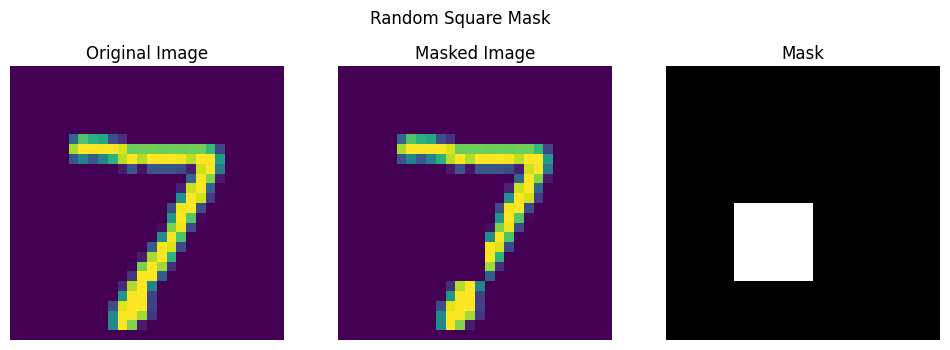

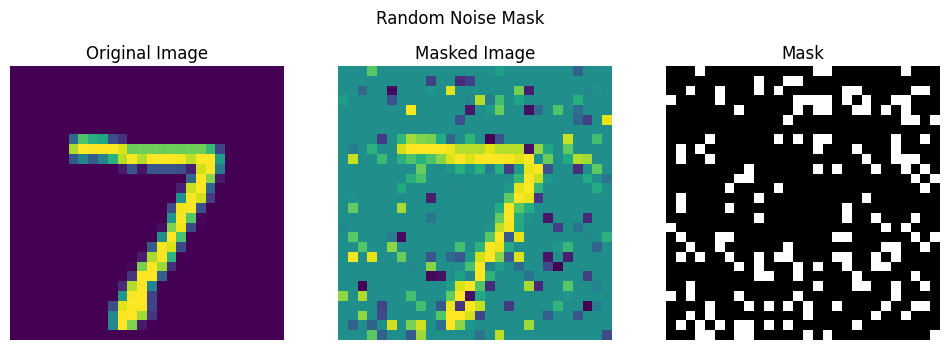

In [16]:
def visualize_masking(original_image, masked_image, mask, title="Masking Example"):
    """
    Visualizes the original, masked images and the mask.

    Args:
        original_image (torch.Tensor): Original image tensor [C, H, W].
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask [H, W].
        title (str): Title for the plot.
    """
    original = original_image.permute(1, 2, 0).cpu().numpy()
    masked = masked_image.permute(1, 2, 0).cpu().numpy()
    mask_display = mask.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(masked)
    axs[1].set_title("Masked Image")
    axs[1].axis('off')

    axs[2].imshow(mask_display, cmap='gray')
    axs[2].set_title("Mask")
    axs[2].axis('off')

    plt.suptitle(title)
    plt.show()

# Example usage
# Assuming `sample_image` is a tensor [C, H, W] from your dataset
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0]  # Take the first image

masked_image_square, mask_square = apply_random_square_mask(sample_image, mask_size=8)
visualize_masking(sample_image, masked_image_square, mask_square, title="Random Square Mask")

masked_image_noise, mask_noise = apply_random_noise_mask(sample_image, noise_fraction=0.2)
visualize_masking(sample_image, masked_image_noise, mask_noise, title="Random Noise Mask")

In [17]:
def inpaint_image(model, masked_image, mask, device, num_steps=1000, lr=0.1):
    """
    Inpaints the masked regions of an image by maximizing the log-likelihood under the flow model.

    Args:
        model (nn.Module): Trained normalizing flow model.
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask tensor [H, W], 1 for masked pixels.
        device (torch.device): Device for computations.
        num_steps (int): Number of optimization steps.
        lr (float): Learning rate for the optimizer.

    Returns:
        inpainted_image (torch.Tensor): Inpainted image tensor [C, H, W].
    """
    model.eval()  # Set model to evaluation mode

    # Clone the masked image to avoid modifying the original
    inpainted_image = masked_image.clone().to(device).unsqueeze(0)  # Shape [1, C, H, W]
    mask = mask.unsqueeze(0).unsqueeze(0).to(device)  # Shape [1, 1, H, W]

    # TODO:
    # Initialize the missing pixels to zeros (can also use random noise)
    # Create a tensor that will hold the missing pixels
    missing_pixels = torch.zeros(1, inpainted_image.shape[1], inpainted_image.shape[2], inpainted_image.shape[3]).to(device)


    # Make missing_pixels a learnable parameter
    missing_pixels = torch.nn.Parameter(missing_pixels)

    # Define optimizer
    optimizer = optim.Adam([missing_pixels], lr=lr)

    for step in tqdm(range(num_steps), desc="Inpainting"):
        optimizer.zero_grad()

        # Reconstruct the full image by combining observed and missing pixels
        full_image = inpainted_image * (1 - mask) + missing_pixels * mask

        # Backpropagation ( model.forward_kld() gives the log prob )
        loss = model.forward_kld(full_image)
        loss.backward()
        optimizer.step()


        with torch.no_grad():
        # clamp the missing pixels to valid range (e.g., [0, 1])
          torch.clamp(missing_pixels, 0, 1)


        if (step + 1) % 100 == 0:
            print(f"Step [{step+1}/{num_steps}], Loss: {loss.item():.4f}")

    inpainted_image = inpainted_image * (1 - mask) + missing_pixels * mask
    torch.clamp(inpainted_image, 0, 1)
    return inpainted_image


In [18]:
# Example usage with a batch of 4 images
batch_size = 4
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:batch_size]
sample_labels = sample_labels[:batch_size]

# Apply random square masks to the batch
masked_images = []
masks = []
inpainted_images = []

for img in sample_images:
    masked_img, mask = apply_random_square_mask(img, mask_size=8)
    masked_images.append(masked_img)
    masks.append(mask)
    inpainted_images.append(inpaint_image(model, masked_img, mask, device, num_steps=1000, lr=0.1))

masked_images = torch.stack(masked_images)
masks = torch.stack(masks)
inpainted_images = torch.stack(inpainted_images)

Inpainting:  10%|█         | 100/1000 [00:12<03:33,  4.21it/s]

Step [100/1000], Loss: -2986.8521


Inpainting:  20%|██        | 201/1000 [00:23<01:17, 10.33it/s]

Step [200/1000], Loss: -3074.0769


Inpainting:  30%|███       | 301/1000 [00:33<01:26,  8.11it/s]

Step [300/1000], Loss: -3129.2998


Inpainting:  40%|████      | 402/1000 [00:44<00:58, 10.26it/s]

Step [400/1000], Loss: -3147.6531


Inpainting:  50%|█████     | 501/1000 [00:54<00:47, 10.47it/s]

Step [500/1000], Loss: -3213.9941


Inpainting:  60%|██████    | 600/1000 [01:04<00:37, 10.72it/s]

Step [600/1000], Loss: -3130.0386


Inpainting:  70%|███████   | 701/1000 [01:15<00:26, 11.41it/s]

Step [700/1000], Loss: -3264.3108


Inpainting:  80%|████████  | 801/1000 [01:25<00:18, 10.51it/s]

Step [800/1000], Loss: -3248.9731


Inpainting:  90%|█████████ | 901/1000 [01:35<00:11,  8.28it/s]

Step [900/1000], Loss: -3258.6689


Inpainting: 100%|██████████| 1000/1000 [01:45<00:00,  9.51it/s]


Step [1000/1000], Loss: -3274.1523


Inpainting:  10%|█         | 100/1000 [00:10<01:22, 10.93it/s]

Step [100/1000], Loss: -3182.7192


Inpainting:  20%|██        | 202/1000 [00:20<01:13, 10.81it/s]

Step [200/1000], Loss: -3240.3228


Inpainting:  30%|███       | 302/1000 [00:31<01:10,  9.95it/s]

Step [300/1000], Loss: -3222.4053


Inpainting:  40%|████      | 401/1000 [00:41<01:04,  9.31it/s]

Step [400/1000], Loss: -3239.8311


Inpainting:  50%|█████     | 501/1000 [00:51<01:01,  8.07it/s]

Step [500/1000], Loss: -3242.3970


Inpainting:  60%|██████    | 600/1000 [01:01<00:37, 10.56it/s]

Step [600/1000], Loss: -3229.0806


Inpainting:  70%|███████   | 701/1000 [01:12<00:27, 10.75it/s]

Step [700/1000], Loss: -3238.7881


Inpainting:  80%|████████  | 801/1000 [01:22<00:18, 10.75it/s]

Step [800/1000], Loss: -3228.4492


Inpainting:  90%|█████████ | 902/1000 [01:33<00:08, 10.91it/s]

Step [900/1000], Loss: -3237.8721


Inpainting: 100%|██████████| 1000/1000 [01:43<00:00,  9.65it/s]


Step [1000/1000], Loss: -3252.0977


Inpainting:  10%|█         | 101/1000 [00:10<01:52,  7.98it/s]

Step [100/1000], Loss: -3522.1211


Inpainting:  20%|██        | 202/1000 [00:20<01:21,  9.77it/s]

Step [200/1000], Loss: -3581.4312


Inpainting:  30%|███       | 301/1000 [00:31<01:10,  9.97it/s]

Step [300/1000], Loss: -3617.9739


Inpainting:  40%|████      | 401/1000 [00:41<01:02,  9.52it/s]

Step [400/1000], Loss: -3599.4229


Inpainting:  50%|█████     | 501/1000 [00:52<00:47, 10.42it/s]

Step [500/1000], Loss: -3641.0327


Inpainting:  60%|██████    | 601/1000 [01:02<00:38, 10.44it/s]

Step [600/1000], Loss: -3638.9854


Inpainting:  70%|███████   | 701/1000 [01:12<00:41,  7.15it/s]

Step [700/1000], Loss: -3651.9534


Inpainting:  80%|████████  | 801/1000 [01:22<00:19, 10.42it/s]

Step [800/1000], Loss: -3633.3525


Inpainting:  90%|█████████ | 901/1000 [01:33<00:09, 10.83it/s]

Step [900/1000], Loss: -3644.9023


Inpainting: 100%|██████████| 1000/1000 [01:43<00:00,  9.64it/s]


Step [1000/1000], Loss: -3662.2698


Inpainting:  10%|█         | 102/1000 [00:10<01:27, 10.26it/s]

Step [100/1000], Loss: -2910.1821


Inpainting:  20%|██        | 201/1000 [00:21<01:15, 10.59it/s]

Step [200/1000], Loss: -2941.8489


Inpainting:  30%|███       | 301/1000 [00:31<01:40,  6.95it/s]

Step [300/1000], Loss: -2945.9277


Inpainting:  40%|████      | 402/1000 [00:41<00:56, 10.60it/s]

Step [400/1000], Loss: -2933.9314


Inpainting:  50%|█████     | 501/1000 [00:52<00:50,  9.87it/s]

Step [500/1000], Loss: -2938.0908


Inpainting:  60%|██████    | 601/1000 [01:02<00:41,  9.50it/s]

Step [600/1000], Loss: -2952.6345


Inpainting:  70%|███████   | 701/1000 [01:13<00:28, 10.66it/s]

Step [700/1000], Loss: -2972.7031


Inpainting:  80%|████████  | 801/1000 [01:24<00:20,  9.55it/s]

Step [800/1000], Loss: -2938.6235


Inpainting:  90%|█████████ | 901/1000 [01:35<00:10,  9.58it/s]

Step [900/1000], Loss: -2955.8157


Inpainting: 100%|██████████| 1000/1000 [01:45<00:00,  9.51it/s]

Step [1000/1000], Loss: -2954.0188


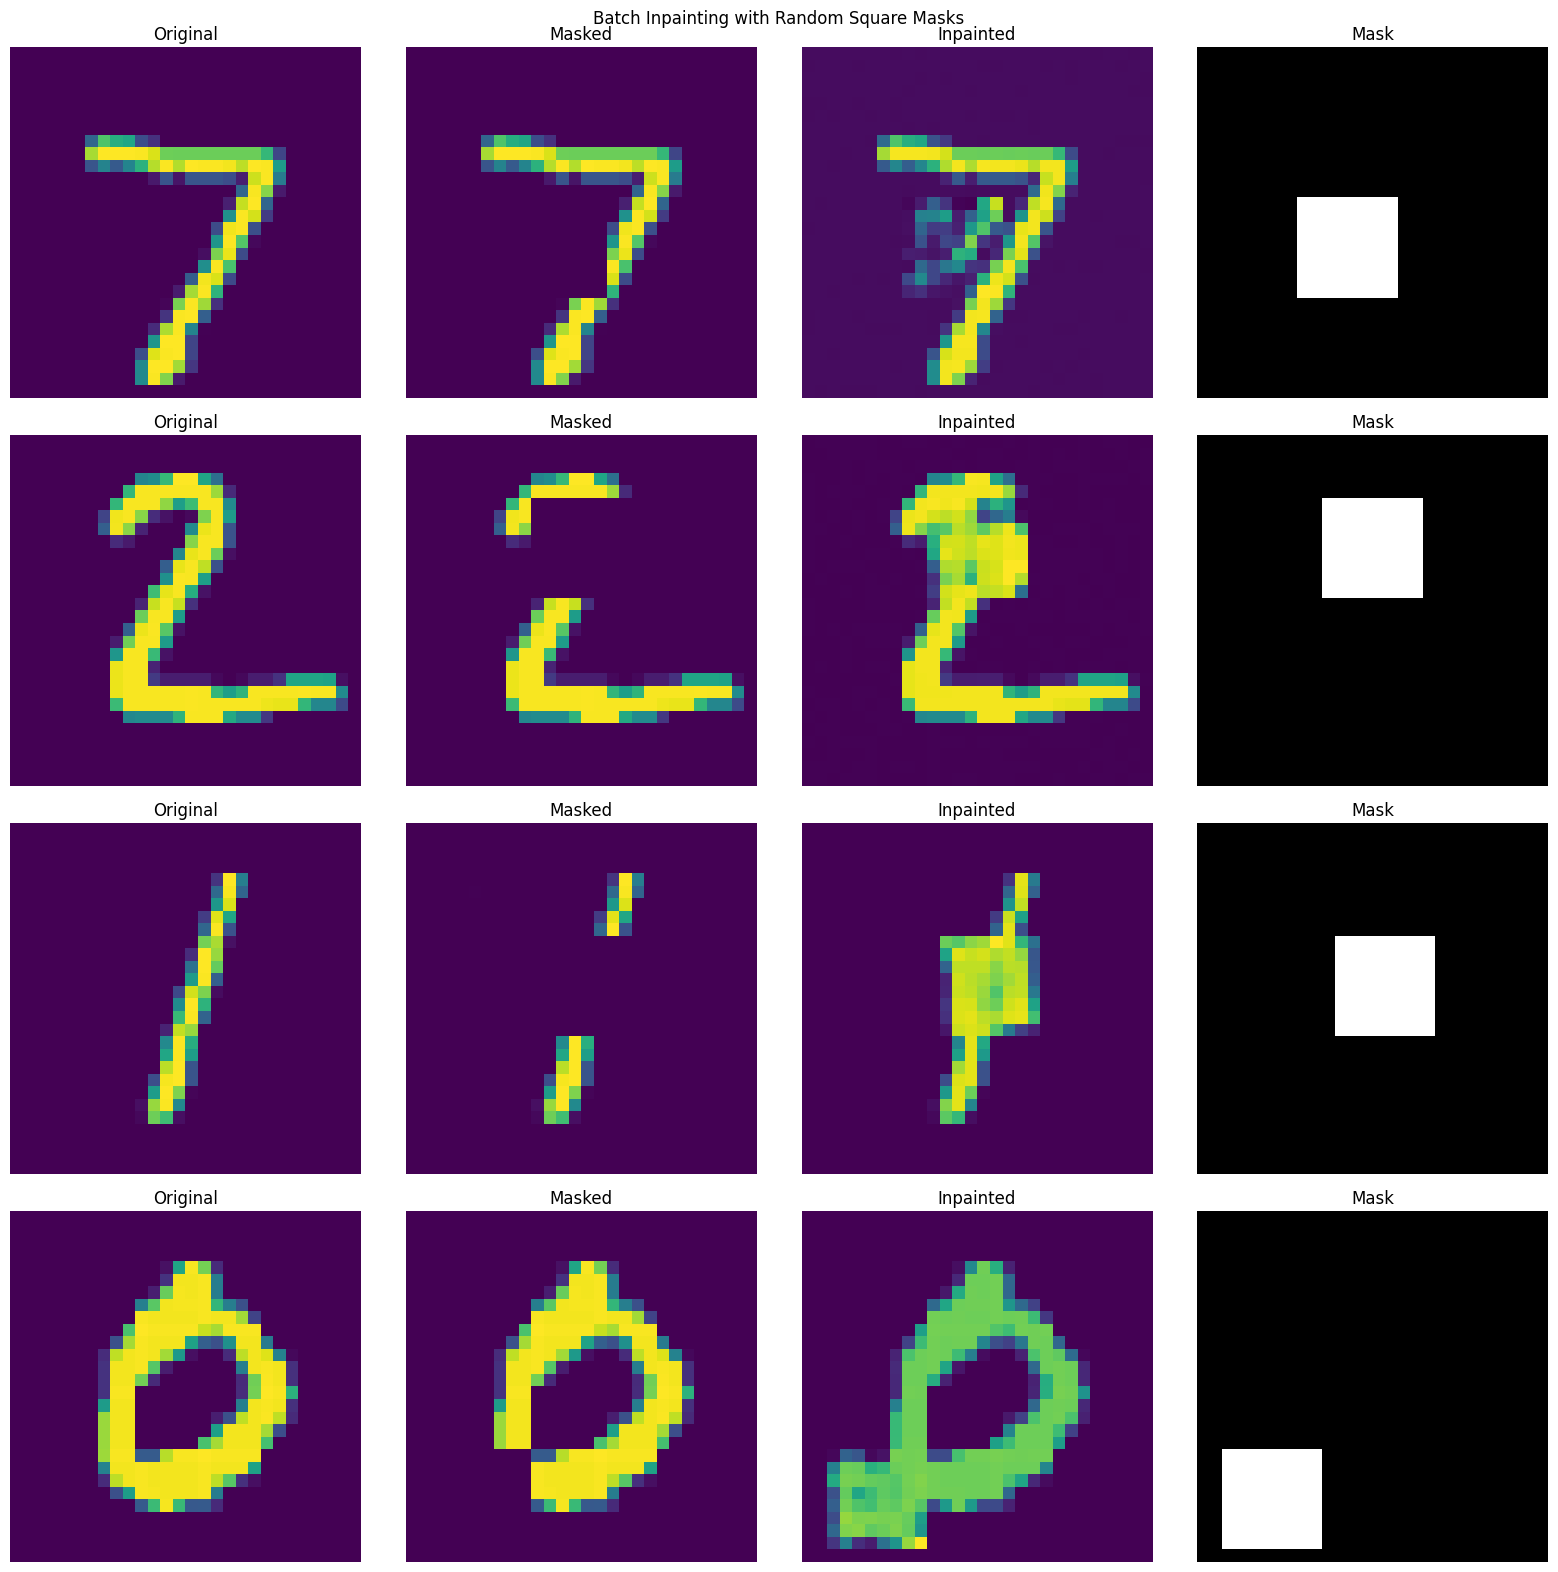

In [19]:
# Visualize the results (this is a suggested code, you can change this)
def visualize_batch_inpainting(originals, masked, inpainted, masks, title="Batch Inpainting Results"):
    """
    Visualizes a batch of original, masked, and inpainted images with their masks.

    Args:
        originals (torch.Tensor): Original images [N, C, H, W].
        masked (torch.Tensor): Masked images [N, C, H, W].
        inpainted (torch.Tensor): Inpainted images [N, C, H, W].
        masks (torch.Tensor): Masks [N, H, W].
        title (str): Title for the plot.
    """
    N = originals.size(0)
    fig, axs = plt.subplots(N, 4, figsize=(16, 4 * N))

    for i in range(N):

        original = originals[i].permute(1, 2, 0).detach().cpu().numpy()
        masked_img = masked[i].permute(1, 2, 0).detach().cpu().numpy()
        inpainted_img = inpainted[i].reshape(-1, 28, 28).permute(1, 2, 0).detach().cpu().numpy()
        mask_display = masks[i].detach().cpu().numpy()

        axs[i, 0].imshow(original)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(masked_img)
        axs[i, 1].set_title("Masked")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(inpainted_img)
        axs[i, 2].set_title("Inpainted")
        axs[i, 2].axis('off')

        axs[i, 3].imshow(mask_display, cmap='gray')
        axs[i, 3].set_title("Mask")
        axs[i, 3].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_batch_inpainting(sample_images, masked_images, inpainted_images, masks, title="Batch Inpainting with Random Square Masks")
